In [3]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.1.0
Numpy version: 1.24.2
Pytorch version: 2.0.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.0.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, 

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpksnal3ug


In [3]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):

    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [1]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return train_loader, val_loader, validation_files, train_ds

In [2]:
data_dir = "../data_brats/brats2021challenge"
json_list = "../data_brats/brats21_folds.json"
roi = (128, 128, 128)
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10
train_loader, val_loader, val_files, train_ds = get_loader(batch_size, data_dir, json_list, fold, roi)

NameError: name 'datafold_read' is not defined

image shape: (240, 240, 155), label shape: (240, 240, 155)


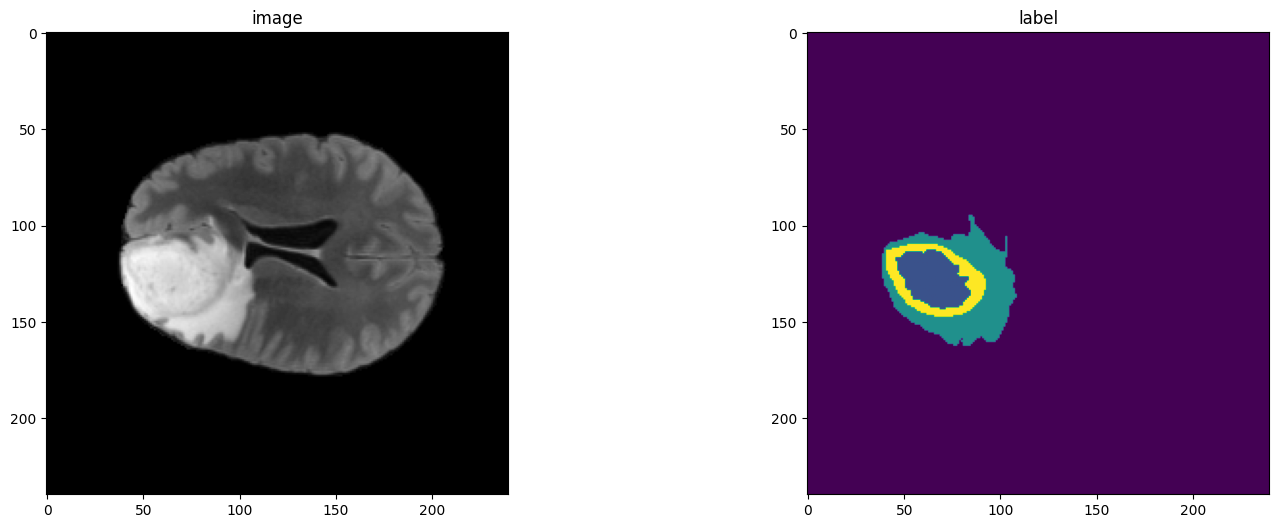

In [7]:
img_add = os.path.join(data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_flair.nii.gz")
label_add = os.path.join(data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_seg.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

In [9]:
model = torch.nn.DataParallel(model)

In [10]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [11]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg

In [12]:
val_acc_max = 0.0
dices_tc = []
dices_wt = []
dices_et = []
dices_avg = []
loss_epochs = []
trains_epoch = []

In [13]:
model.train()
start_time = time.time()
run_loss = AverageMeter()
for idx, batch_data in enumerate(train_loader):
    data, target = batch_data["image"].to(device), batch_data["label"].to(device)
    logits = model(data)
    loss = dice_loss(logits, target)
    loss.backward()
    optimizer.step()
    run_loss.update(loss.item(), n=batch_size)
    print(
        "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(train_loader)),
        "loss: {:.4f}".format(run_loss.avg),
        "time {:.2f}s".format(time.time() - start_time),
    )
    start_time = time.time()

/home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future 

NameError: name 'epoch' is not defined

In [26]:
for epoch in range(1, 2):
    print(time.ctime(), "Epoch:", epoch)
    epoch_time = time.time()
    
    ##### Training #####
    
        break
    
    train_loss = run_loss.avg
    
    print(
        "Final training  {}/{}".format(epoch, max_epochs - 1),
        "loss: {:.4f}".format(train_loss),
        "time {:.2f}s".format(time.time() - epoch_time),
    )

Fri Mar 24 19:25:24 2023 Epoch: 1


/home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/home/vedatb/senior-project/bbm47980_bts/.venv/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and U

NameError: name 'loader' is not defined

In [28]:
print(
    "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(train_loader)),
    "loss: {:.4f}".format(run_loss.avg),
    "time {:.2f}s".format(time.time() - start_time),
)

Epoch 1/100 0/501 loss: 0.9910 time 109.29s


In [41]:
batch_data.keys()

dict_keys(['fold', 'image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord'])

In [15]:
batch_data["image"].shape

torch.Size([2, 4, 128, 128, 128])

In [ ]:
batch_data["label"].shape

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


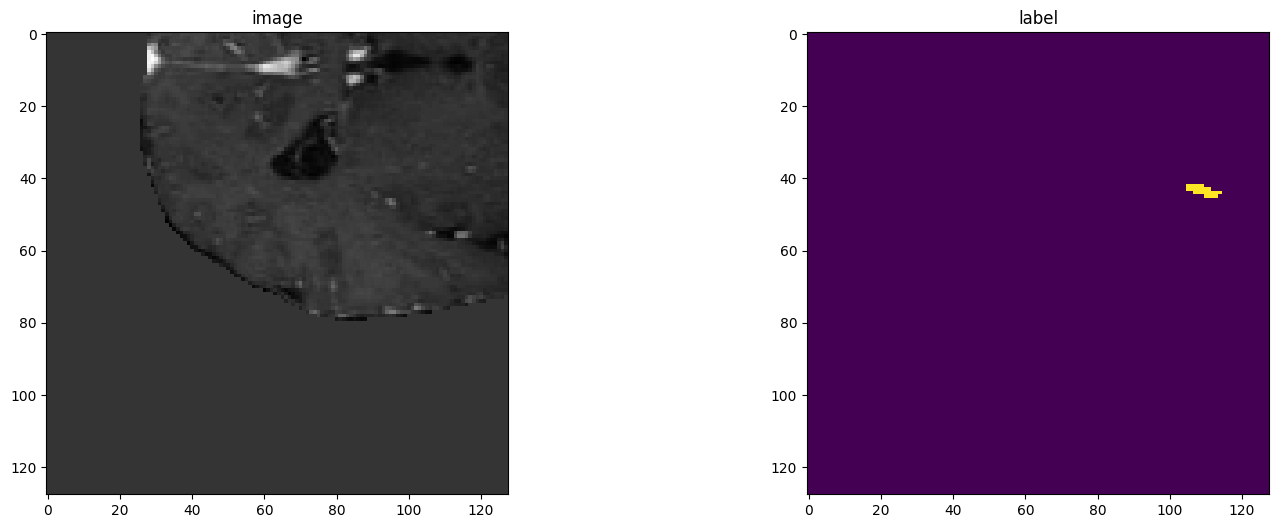

In [29]:
img = batch_data["image"][0][1]
label = batch_data["label"][0][1]
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

In [34]:
batch_data["image"].shape

torch.Size([2, 4, 128, 128, 128])

In [35]:
batch_data["label"].shape

torch.Size([2, 3, 128, 128, 128])

In [40]:
logits.dtype

torch.float32

In [6]:
logits.shape

NameError: name 'logits' is not defined

In [32]:
batch_data["image"][0].dtype

torch.float32

In [33]:
batch_data.keys()

dict_keys(['fold', 'image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord'])